In [1]:
import csv
from collections import defaultdict
import json
from os.path import join
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
import os

import pandas as pd

def print_args(path):
    with open(path) as args:
        print(args.read())
        
def read_run_results(run_name, verbose=False):
    print('Reading results for {}'.format(run_name))
    print(' ')
    
    if verbose:
        print('AGENT ARGS')
        agent_args = join('/Users/adam/git/energy_py/energy_py/experiments/results/', run_name, 'agent_args.txt')
        print_args(agent_args)
        print('ENV ARGS')
        env_args = os.path.join('/Users/adam/git/energy_py/energy_py/experiments/results/', run_name, 'env_args.txt')
        print_args(env_args)

    results = []
    results_path = join('/Users/adam/git/energy_py/energy_py/experiments/results/', run_name, 'env_histories')
    for root, dirs, files in os.walk(results_path):
        for f in files:
            results.append(pd.read_csv(join(root, f), index_col=0, parse_dates=True))

    print('Read {} results'.format(len(results)))
    print(' ')

    return results

def process_result(result, useful_cols, verbose=False):
    result = result[useful_cols]

    total_reward = result['reward'].sum()
#     num_actions = result['flex_counter'].max()

    output = {
        #'number flex actions': num_actions,
        'total episode reward [$]': total_reward
    }

    if verbose:
        groups = {}
        groups['electricity_price'] = [np.mean, np.max, np.min]
        groups['flex_up'] = [np.sum]
        groups['flex_down'] = [np.sum]
        groups['flex_up'] = [np.sum]
        
        group = result.groupby('flex_counter').agg(groups)
        print(group)

        for k, v in output.items():
            print('{} {:2.0f}'.format(k, v))

    return output

def plot_result(hist):
    hist = hist.iloc[-200:, :]
    f, ax = plt.subplots(nrows=3, figsize=(20, 10))

    #hist.plot(y='flex_action', x=hist.index, color='g', ax=ax[0])
    #_ = ax[0].set_title('flex_action [MW]')

    hist.plot(y='reward', x=hist.index, color='r', ax=ax[1])
    #_ = ax[1].set_title('reward [$/5min]')

    hist.plot(y='electricity_price', x=hist.index, color='b', ax=ax[2])
    #_ = ax[2].set_title('electricity_price [$/MWh]')
    return f
        

class Results(object):
    """
    Processes environment histories
    
    args
        run_name (path) /expt_name/run_name
        verbose (bool)
    """
    def __init__(self, run_name, cols, verbose=False):
        self.run_name = run_name
        self.cols = cols
        
        self.results = read_run_results(self.run_name, verbose)
        
        self.episode_length = self.results[-1].shape[0]
        
        self.episode_summary = self.summarize_results()
        
    def summarize_results(self):
        result_summary = defaultdict(list)

        for result in self.results:
            out = process_result(result, self.cols)
            for k, v in out.items():
                result_summary[k].append(v)
                
        episode_summary = pd.DataFrame().from_dict(result_summary)
        
        num_5mins_per_day = 12 * 24
        num_5mins_per_year = num_5mins_per_day * 365
        
        avg_ep_reward = episode_summary['total episode reward [$]'].mean()
        avg_daily_reward = avg_ep_reward / (self.episode_length / num_5mins_per_day)
        avg_annual_reward = avg_ep_reward / (self.episode_length / num_5mins_per_year)

        print('Results for {}'.format(self.run_name))
        print(' ')
        print('avg episode reward [$] {:2.0f}'.format(avg_ep_reward))
        print('avg daily reward [$] {:2.0f}'.format(avg_daily_reward))
        print('avg annual reward [$] {:2.0f}'.format(avg_annual_reward))

        #num_eps_no_flex = episode_summary[episode_summary['number flex actions'] == 0].shape[0]
        #print('num episodes without flexing {} of {} days'.format(num_eps_no_flex, episode_summary.shape[0]))
        
        num_eps_losses = episode_summary[episode_summary['total episode reward [$]'] < 0].shape[0]
        print('num episodes of losses {}'.format(num_eps_losses))
        
        all_results = pd.concat(self.results, axis=0)
        monthly = all_results['reward'].groupby(all_results.index.month).sum()
        print(monthly)
        
        return out

In [20]:
res = Results('new_flex/DEFAULT', ['electricity_price', 'reward'], verbose=True)

Reading results for new_flex/DEFAULT
 
AGENT ARGS
learn_path,/Users/adam/git/energy_py/energy_py/experiments/results/new_flex/tensorboard/DEFAULT/learn
total_steps,1
act_path,/Users/adam/git/energy_py/energy_py/experiments/results/new_flex/tensorboard/DEFAULT/act
seed,2
env,<energy_py flex-v3 environment>
sess,<tensorflow.python.client.session.Session object at 0x11fb619b0>
agent_id,random
env_repr,<energy_py flex-v3 environment>

ENV ARGS
dataset,example
env_id,flex
episode_length,0
episode_sample,full

Read 1 results
 
Results for new_flex/DEFAULT
 
avg episode reward [$] -986
avg daily reward [$] -141
avg annual reward [$] -51461
num episodes of losses 1
4   -986.441892
Name: reward, dtype: float64


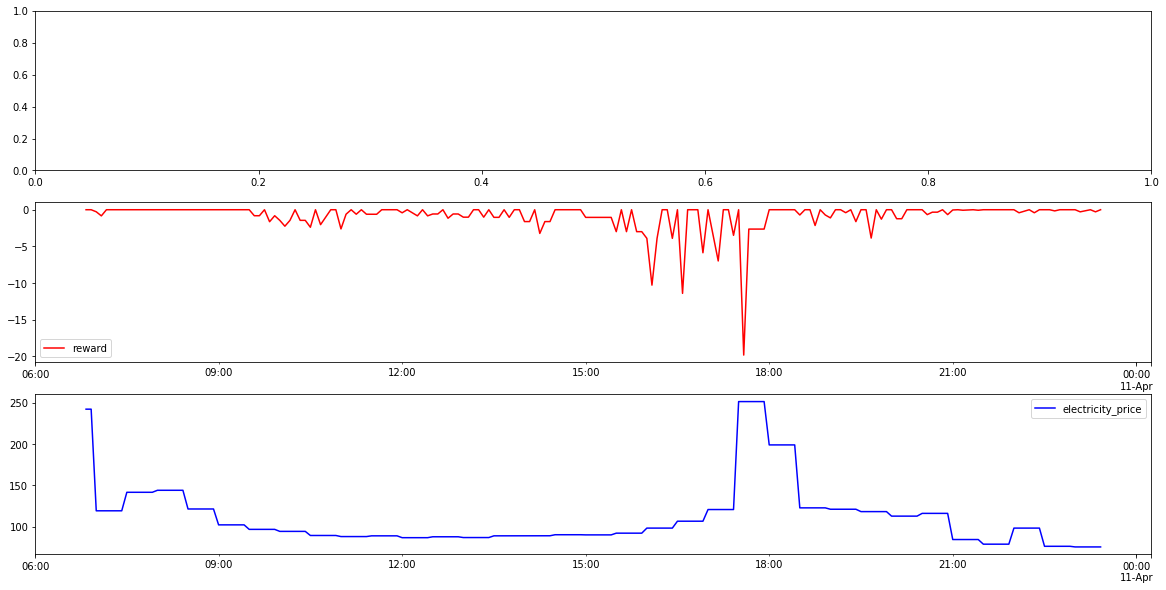

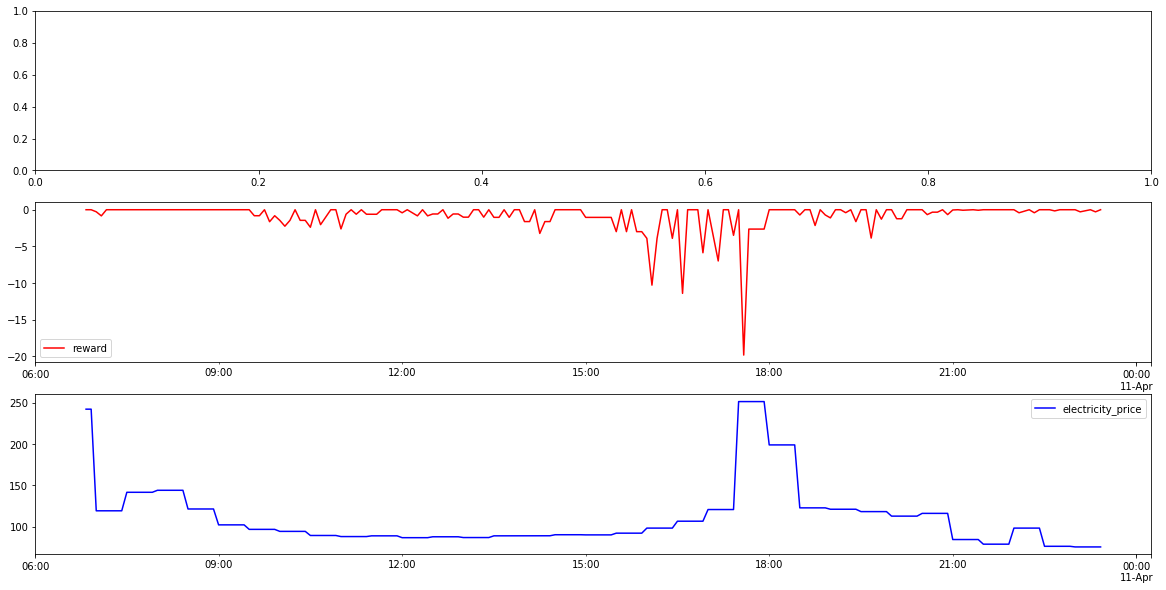

In [22]:
plot_result(res.results[0])